In [80]:
import os
import matplotlib.pyplot as plt
import skimage
import numpy as np
from scipy import ndimage as ndi
from skimage import io

# Importação de Imagens

In [3]:
filename = os.path.join(skimage.data_dir, 'fotos/bios/GUU-Draco-Amo9-29Mai70-515-29,1-2-0,5-DIR.jpg')
img = io.imread('photos/bios/GUU-Draco-Amo9-29Mai70-515-29,1-2-0,5-DIR.jpg')
print(img.shape)


(574, 764, 3)


# Separação por canais:

## Red

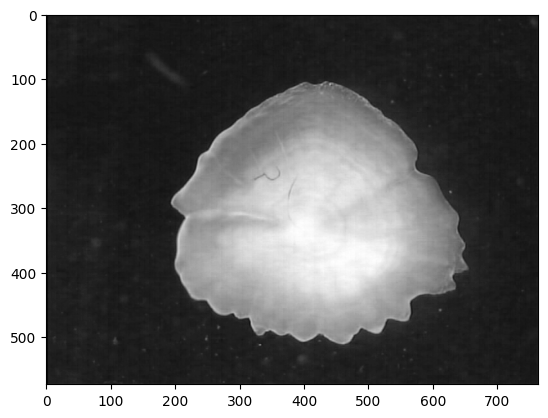

In [4]:
plt.imshow(img[:,:,0], cmap=plt.cm.gray)

# Green

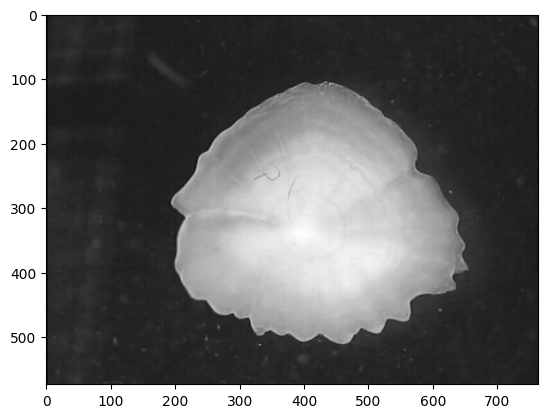

In [15]:
plt.imshow(img[:,:,1], cmap=plt.cm.gray)

# Blue

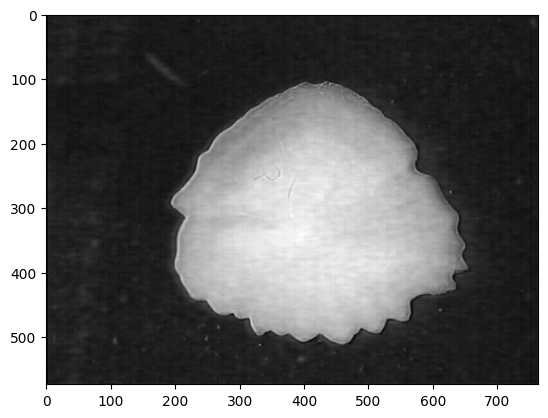

In [16]:
plt.imshow(img[:,:,2], cmap=plt.cm.gray)

## Mix

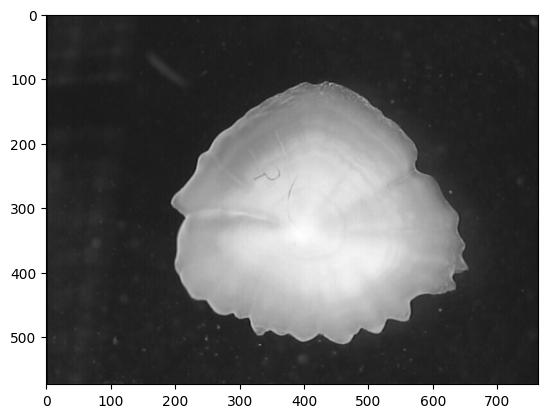

In [14]:
img_g = skimage.color.rgb2gray(img)
plt.imshow(img_g, cmap=plt.cm.gray)

# Remoção de ruído

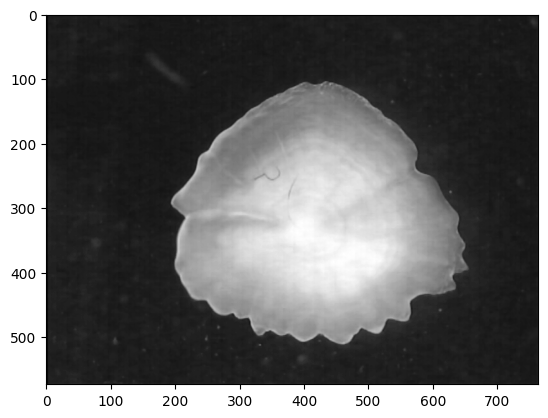

In [5]:
img_f = skimage.filters.median(img[:,:,0])
plt.imshow(img_f, cmap=plt.cm.gray)

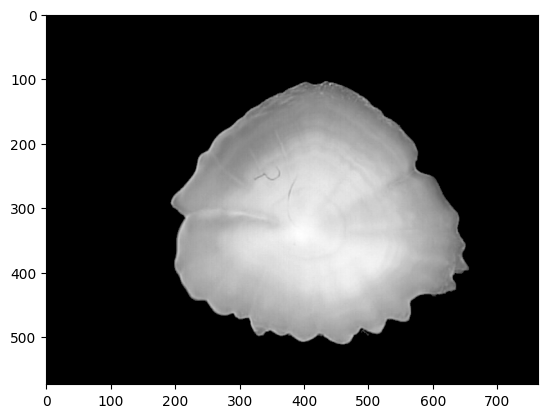

In [47]:
img_f = skimage.filters.apply_hysteresis_threshold(img_g, low = 0.2, high = 0.8)
plt.imshow(img_f)

teste = img_g * img_f
plt.imshow(teste, cmap=plt.cm.gray)

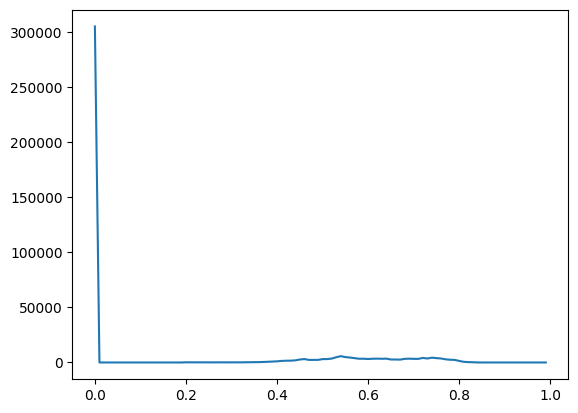

In [50]:
histogram, bin_edges = np.histogram(teste, bins=100, range=(0, 1))
plt.plot(bin_edges[0:-1], histogram)

In [134]:
def afinador(input):
    min = np.partition(input,1)[1]
    max = input.max()
    res = (input-min)/(max - min)
    return res

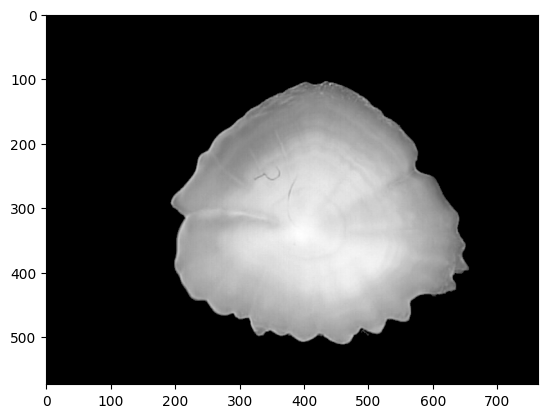

In [135]:
plt.imshow(afinador(teste), cmap=plt.cm.gray)

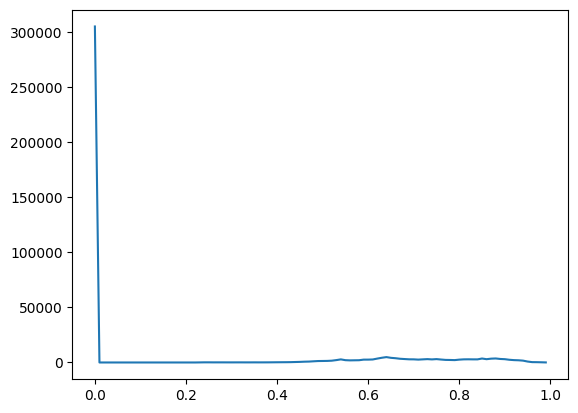

In [136]:
afinador(teste).max()
histogram, bin_edges = np.histogram(afinador(teste), bins=100, range=(0, 1))
plt.plot(bin_edges[0:-1], histogram)

In [137]:
teste.max()

0.8472450980392157

# mascara hialinos

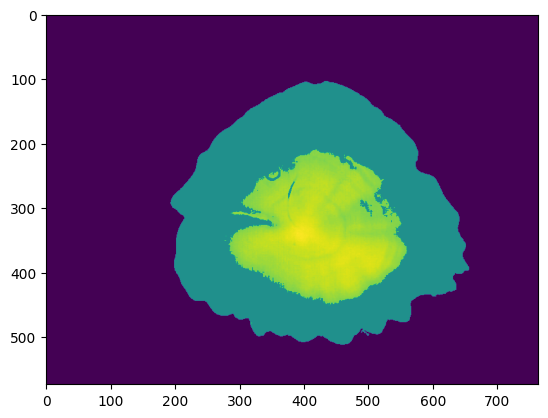

In [138]:
temp = afinador(teste)
mask_h = np.where(((temp>0) & (temp < 0.8)),0.5,temp)
plt.imshow(mask_h, cmap=plt.cm.gray)
plt.imshow(mask_h)

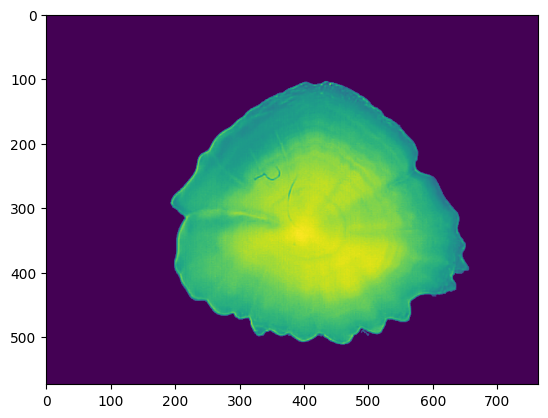

In [141]:
plt.imshow(skimage.filters.unsharp_mask(temp))

In [40]:
dir(skimage)
dir(skimage.filters)

['LPIFilter2D',
 'apply_hysteresis_threshold',
 'butterworth',
 'correlate_sparse',
 'difference_of_gaussians',
 'farid',
 'farid_h',
 'farid_v',
 'frangi',
 'gabor',
 'gabor_kernel',
 'gaussian',
 'hessian',
 'inverse',
 'laplace',
 'median',
 'meijering',
 'prewitt',
 'prewitt_h',
 'prewitt_v',
 'rank',
 'rank_order',
 'roberts',
 'roberts_neg_diag',
 'roberts_pos_diag',
 'sato',
 'scharr',
 'scharr_h',
 'scharr_v',
 'sobel',
 'sobel_h',
 'sobel_v',
 'threshold_isodata',
 'threshold_li',
 'threshold_local',
 'threshold_mean',
 'threshold_minimum',
 'threshold_multiotsu',
 'threshold_niblack',
 'threshold_otsu',
 'threshold_sauvola',
 'threshold_triangle',
 'threshold_yen',
 'try_all_threshold',
 'unsharp_mask',
 'wiener',
 'window']

In [11]:
img = skimage.filters.thresholding.threshold_otsu(moon[:,:,1])
mask = moon < img

In [6]:
plt.imshow(mask)

NameError: name 'mask' is not defined

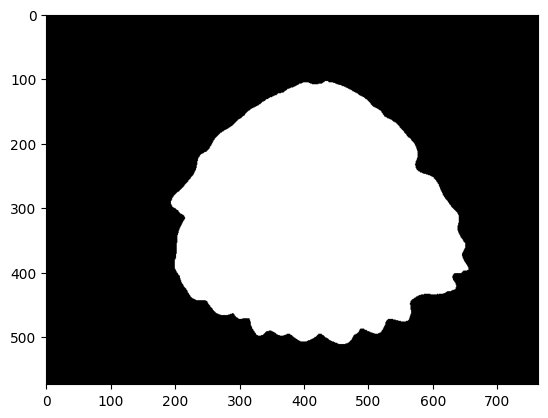

# Função: Prototipo 1:

In [338]:
def processador(imagem, plot:bool=True):
    colapsado = skimage.color.rgb2gray(imagem)

    # detecta a borda e cria uma mascara
    markers = np.zeros_like(colapsado)
    markers[colapsado < 0.1] = 1 # como determinar este valor?
    markers[colapsado> 0.8] = 2 # como determinar este valor?

    edge = skimage.filters.sobel(colapsado)
    segmentation_edge = skimage.segmentation.watershed(edge, markers)


    # limpeza do segmentation edge


    mascara = segmentation_edge-1

    # identifica o objecto maior
    otolito = skimage.filters.apply_hysteresis_threshold(colapsado*segmentation_edge, high = 0.6, low = 0.4) # validar valores
    labeled = ndi.label(otolito)[0]
    otolito = skimage.color.label2rgb(labeled, mascara)

    # identifica o centroide
    largest_nonzero_label = np.argmax(np.bincount(labeled[labeled > 0]))
    binary = labeled == largest_nonzero_label
    skeleton = skimage.morphology.skeletonize(binary)
    g, nodes = skimage.graph.pixel_graph(skeleton, connectivity=2)
    px, distances = skimage.graph.central_pixel(
    g, nodes=nodes, shape=skeleton.shape, partition_size=100)

    centroid = skimage.measure.centroid(labeled > 0)

    # identifica a borda pixel a pixel?
    borda = skimage.measure.find_contours(binary) # em vez de segmentation edge?

    # linha de perfil a partir do centroide
    origin_x, origin_y = px[1], px[0]
    profile = skimage.measure.profile_line(segmentation_edge * colapsado, src = (origin_x, origin_y), dst = (0,0))

    # plots
    if plot:
        f, ax = plt.subplots(3,3, figsize = (40,20))
        ax[0,0].imshow(colapsado, cmap = plt.cm.gray)

        ax[0,1].imshow(segmentation_edge, cmap = plt.cm.gray)

        ax[0,2].imshow(colapsado * mascara, cmap = plt.cm.gray)

        ax[1,0].imshow(otolito, cmap = plt.cm.gray)
        origin = [origin_x, 0]
        dest = [origin_y,0]

        ax[1,1].imshow(skimage.color.label2rgb(skeleton, colapsado*mascara))
        ax[1,1].plot(origin, dest, linewidth = 5, color = 'r')
        ax[1,1].scatter(px[1], px[0], label='graph center')
        ax[1,1].scatter(centroid[1], centroid[0], label='centroid')
        ax[1,1].legend()
        ax[1,1].set_axis_off()
        ax[1,1].set_title('graph center vs centroid')


        ax[1,2].plot(profile)

        ax[2,0].imshow(imagem)
        for contour in borda:
            ax[2,0].plot(contour[:, 1], contour[:, 0], linewidth=4, color = 'r')


    return "sexo"

'sexo'

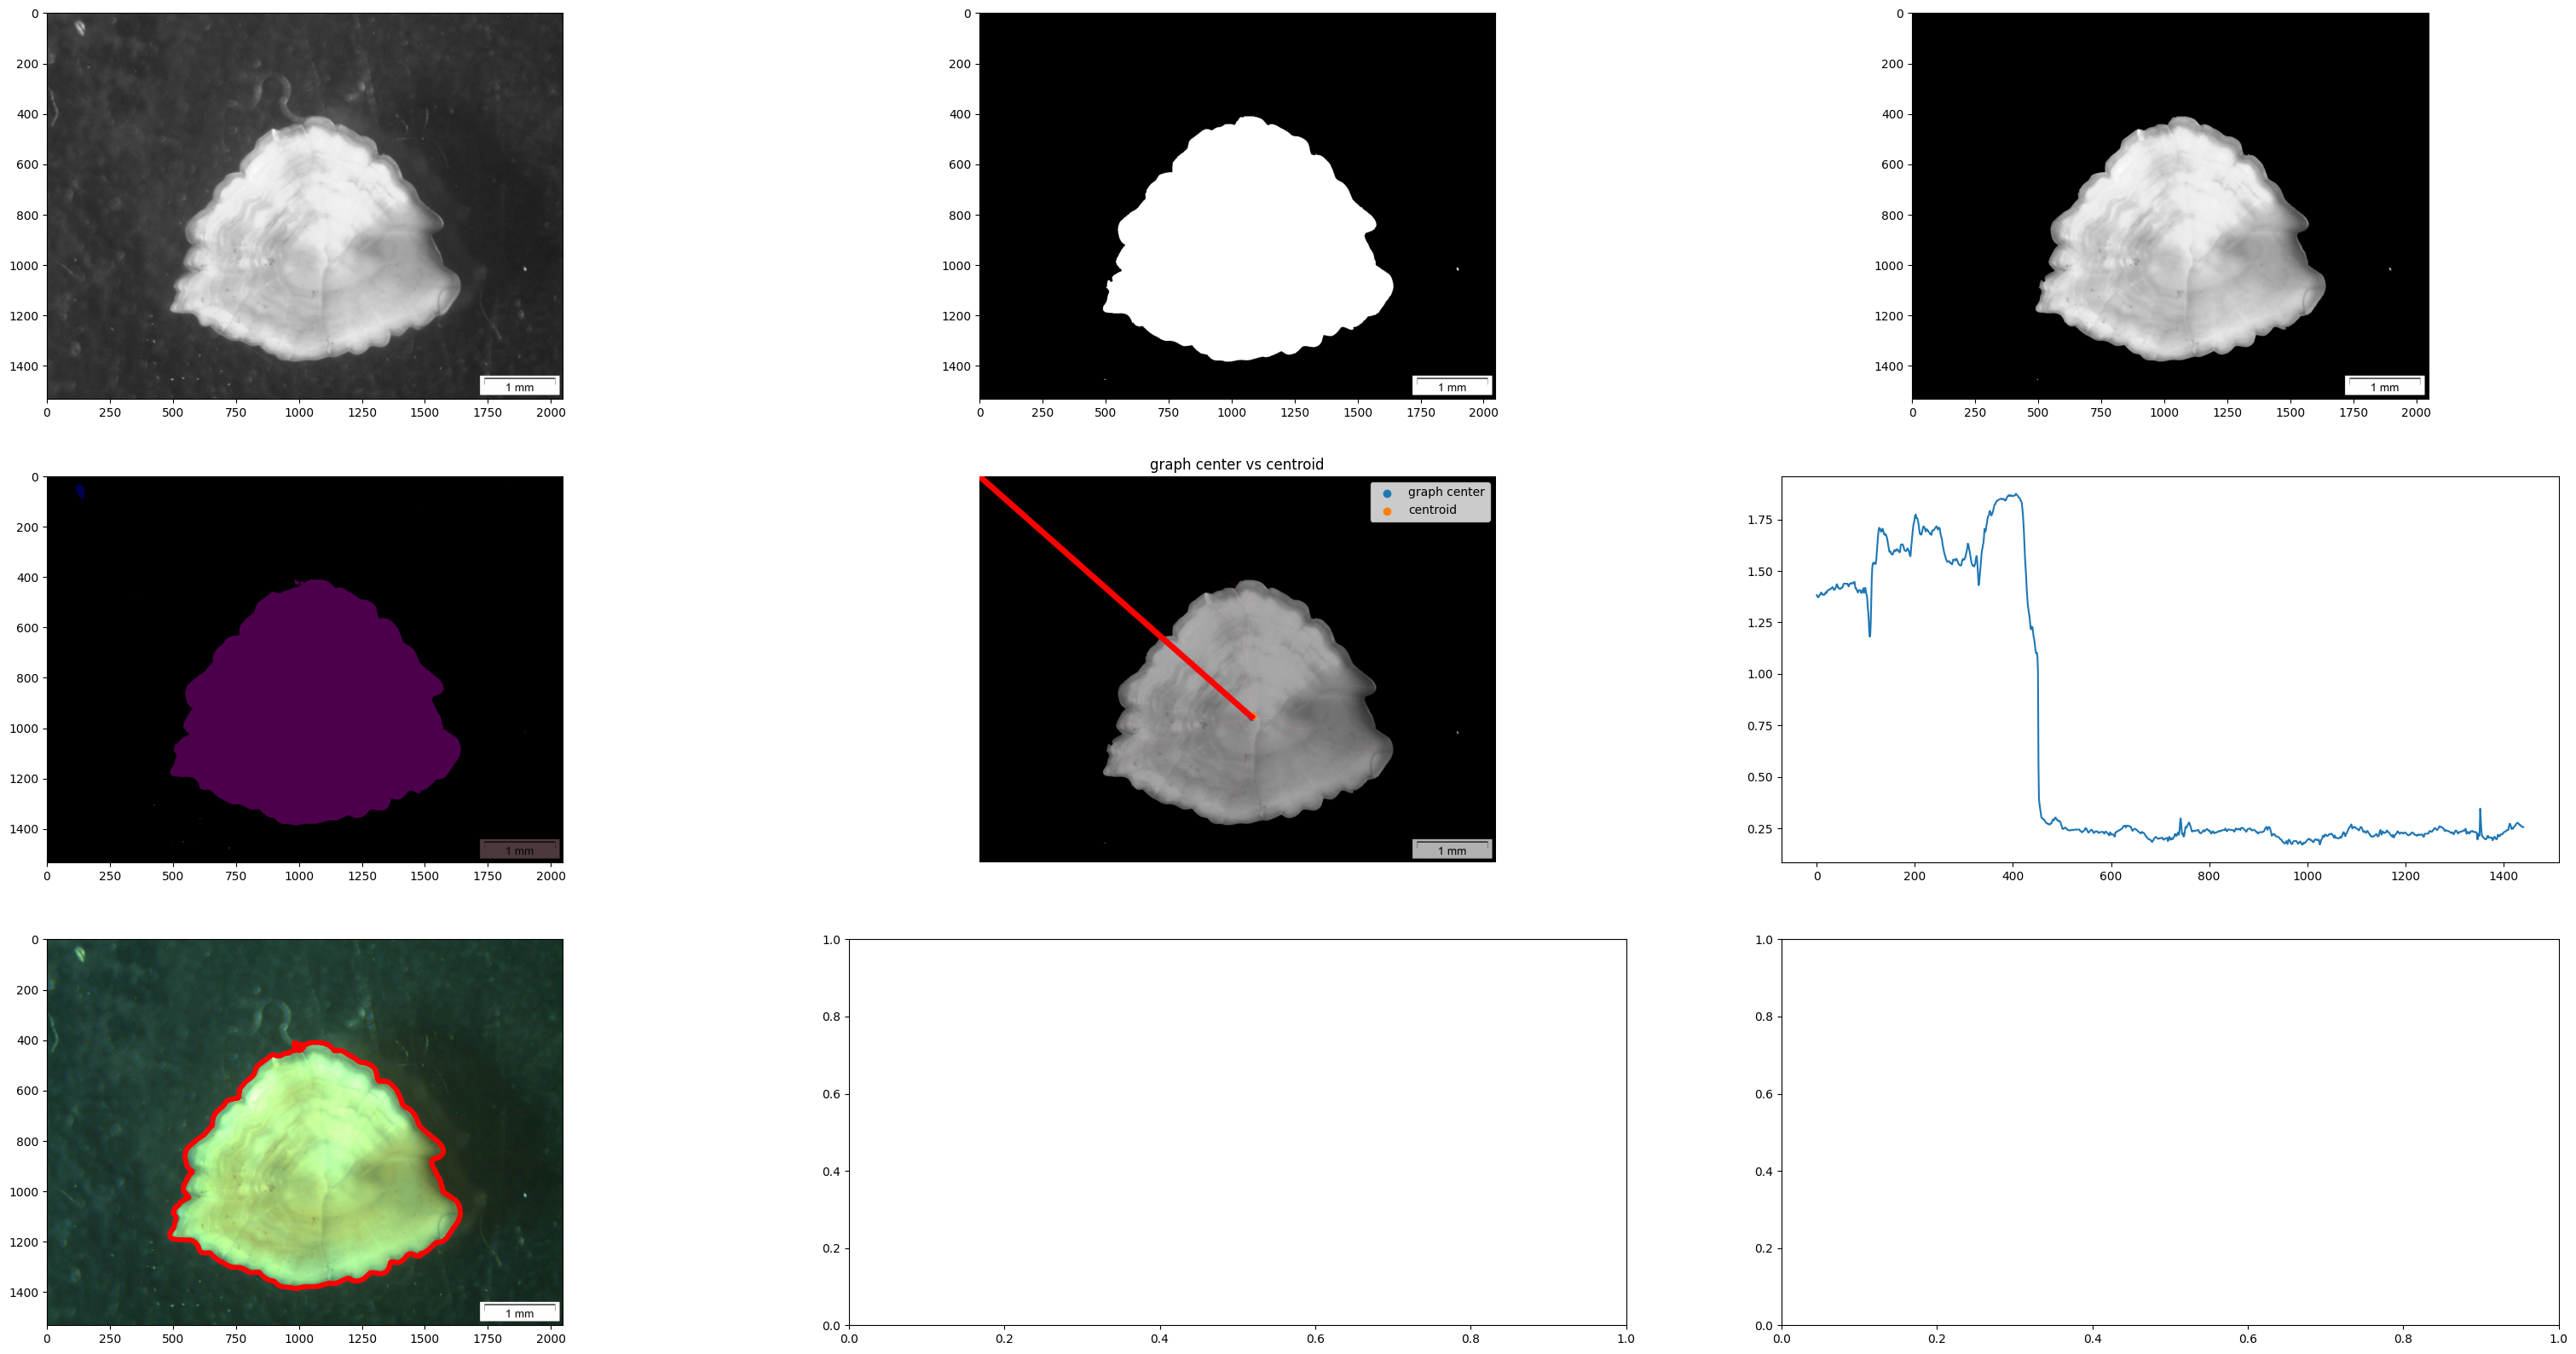

In [339]:
processador(teste_03, True)

In [101]:
import imagecodecs

teste_01 = io.imread('photos/bios/GUU-Draco-Amo9-29Mai70-515-29,1-2-0,5-DIR.jpg')
teste_02 = io.imread('photos/bios/GUU-Mar Roxo-Amo4-27Fev08-202-23,4-2,5-0,5-ESQ.jpg')
teste_03 = io.imread('photos/AM3 CL_20112018/CL19_20112018.jpg')

In [ ]:
processador(teste_01)

In [ ]:
processador(teste_02)

In [ ]:
processador(teste_03)

https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html

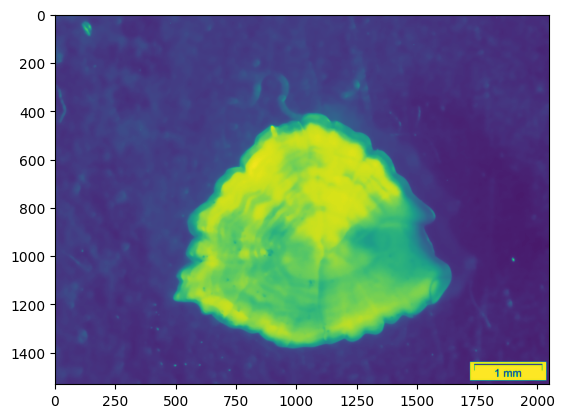

In [323]:
colapsado = skimage.color.rgb2gray(teste_03)
limpa = skimage.restoration.denoise_tv_chambolle(colapsado)
plt.imshow(limpa)

array([[[ 0,  4,  0],
        [ 0,  6,  0],
        [ 8, 15,  7],
        ...,
        [20, 28, 17],
        [26, 29, 20],
        [27, 28, 22]],

       [[ 0,  5,  0],
        [ 0,  7,  0],
        [ 8, 15,  7],
        ...,
        [22, 28, 18],
        [26, 29, 20],
        [27, 28, 22]],

       [[ 0,  6,  0],
        [ 0,  7,  0],
        [ 9, 16,  9],
        ...,
        [22, 28, 18],
        [27, 30, 21],
        [27, 28, 22]],

       ...,

       [[ 0,  8,  0],
        [ 0,  8,  0],
        [ 8, 19,  5],
        ...,
        [19, 25, 13],
        [24, 27, 18],
        [26, 27, 21]],

       [[ 0,  7,  0],
        [ 0,  7,  0],
        [10, 18,  7],
        ...,
        [21, 27, 15],
        [26, 29, 22],
        [27, 28, 23]],

       [[ 0,  6,  0],
        [ 0,  7,  0],
        [13, 20, 12],
        ...,
        [26, 29, 18],
        [30, 31, 25],
        [30, 29, 25]]], dtype=uint8)